<div style="border: 2px solid #2c3e50; border-radius: 10px; padding: 20px; background-color: #f4f6f7;">
  <h1 style="text-align: center; color: #2c3e50; font-family: sans-serif;">Project: Latent Semantic Analysis (LSA)</h1>
  <h3 style="text-align: center; color: #7f8c8d; font-family: sans-serif;">Using Linear Algebra (Truncated SVD) for Document Classification</h3>
  <hr style="border: 1px solid #bdc3c7;">
  <p style="text-align: center; font-family: monospace;">
    <b>Student Name:</b> Avinash Sappati <br>
    <b>Subject:</b> Linear Algebra for AI <br>
    <b>Roll no. :</b> 24AI10001
  </p>
</div>

# 1. Introduction and Objective

**Latent Semantic Analysis (LSA)** is a mathematical method used in Natural Language Processing (NLP) to discover hidden (latent) relationships between words and documents.

## The Objective :
The goal of this project is to take a large, unstructured dataset of text (newsgroup posts) and use **Linear Algebra** to automatically group them into topics (Science, Cars, Graphics) without using any pre-existing labels.

## Mathematical Foundation: SVD
The core of LSA is **Singular Value Decomposition (SVD)**. We start with a Term-Document matrix $C$ and decompose it:

$$C \approx U \Sigma V^T$$

Where:
* $C$: The input matrix (Documents $\times$ Terms).
* $U$: **Document-Concept Matrix** (Relates documents to hidden topics).
* $\Sigma$: **Singular Values** (Diagonal matrix showing the strength of each topic).
* $V^T$: **Concept-Term Matrix** (Relates words to hidden topics).

By keeping only the top $k$ singular values (Truncated SVD), we perform **Dimensionality Reduction**, removing noise and sparsity from the data.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Setting plot style for the report
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 8]


# 2. Dataset Exploration: [The 20 Newsgroups](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

The **20 Newsgroups** dataset is a collection of approximately 18,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang for his paper *Newsweeder: Learning to filter netnews* (1995).

### The 20 Categories
The data is organized into a hierarchy of subjects. Here is the full list of categories available in the dataset:

* **Computers:** `comp.graphics`, `comp.os.ms-windows.misc`, `comp.sys.ibm.pc.hardware`, `comp.sys.mac.hardware`, `comp.windows.x`
* **Science:** `sci.crypt`, `sci.electronics`, `sci.med`, `sci.space`
* **Recreation:** `rec.autos`, `rec.motorcycles`, `rec.sport.baseball`, `rec.sport.hockey`
* **Politics:** `talk.politics.misc`, `talk.politics.guns`, `talk.politics.mideast`
* **Religion:** `soc.religion.christian`, `talk.religion.misc`, `alt.atheism`
* **Misc:** `misc.forsale`

For this project, we will focus on **three specific groups** to test our model's ability to cluster distinct topics:
1.  `sci.space` (Science)
2.  `rec.autos` (Recreation)
3.  `comp.graphics` (Computers)

In [ ]:
categories = ['sci.space', 'rec.autos', 'comp.graphics']
dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

print(f"Number of Documents: {len(dataset.data)}")
print(f"Categories: {dataset.target_names}")

# Getting mail counts for each category
category_counts = np.bincount(dataset.target)
print("\nMail counts per category:")
for i, count in enumerate(category_counts):
    print(f"- {dataset.target_names[i]}: {count} mails")

Number of Documents: 1771
Categories: ['comp.graphics', 'rec.autos', 'sci.space']

Mail counts per category:
- comp.graphics: 584 mails
- rec.autos: 594 mails
- sci.space: 593 mails


In [ ]:
def print_sample_emails(data, target_names, targets):
    seen_categories = set()
    for i in range(len(data)):
        category = target_names[targets[i]]
        if category not in seen_categories:
            print(f"\n{'-'*20} SAMPLE EMAIL: {category.upper()} {'-'*20}")
            print(data[i][:500] + ".... \n[truncated ]")
            seen_categories.add(category)
        if len(seen_categories) == 3:
            break

print_sample_emails(dataset.data, dataset.target_names, dataset.target)


-------------------- SAMPLE EMAIL: SCI.SPACE --------------------
From: prb@access.digex.com (Pat)
Subject: Re: Abyss: breathing fluids
Article-I.D.: access.1psghn$s7r
Organization: Express Access Online Communications USA
Lines: 19
NNTP-Posting-Host: access.digex.net

In article <C4t3K3.498@cck.coventry.ac.uk> enf021@cck.coventry.ac.uk (Achurist) writes:
|
|I believe the reason is that the lung diaphram gets too tired to pump
|the liquid in and out and simply stops breathing after 2-3 minutes.
|So if your in the vehicle ready to go they better not put you on .... 
[truncated ]

-------------------- SAMPLE EMAIL: COMP.GRAPHICS --------------------
From: mmadsen@bonnie.ics.uci.edu (Matt Madsen)
Subject: Re: Please Recommend 3D Graphics Library For Mac.
Nntp-Posting-Host: bonnie.ics.uci.edu
Reply-To: mmadsen@ics.uci.edu (Matt Madsen)
Organization: Univ. of Calif., Irvine, Info. & Computer Sci. Dept.
Lines: 27

Robert G. Carpenter writes:

>Hi Netters,
>
>I'm building a CAD package and n

## The Problem with Raw Text:

- Before processing the text, we must understand the frequency of words. In any natural language, the most frequent words are often grammatical connectors (articles, prepositions) that carry very little semantic meaning.

- If we simply count word frequencies without filtering, our model will be dominated by words like **"the"**, **"of"**, and **"to"**, hiding the actual topics (like "orbit" or "engine").

Let's visualize this "noise" to verify why we need preprocessing.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Count words WITHOUT filtering ( getting top 20 words only )
count_vec = CountVectorizer(stop_words=None, max_features=20)
X_counts = count_vec.fit_transform(dataset.data)

# Sum up counts for each word
sum_words = X_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

df_common = pd.DataFrame(words_freq, columns=['Word', 'Frequency'])

/tmp/ipython-input-3095909048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=df_common, palette='viridis')


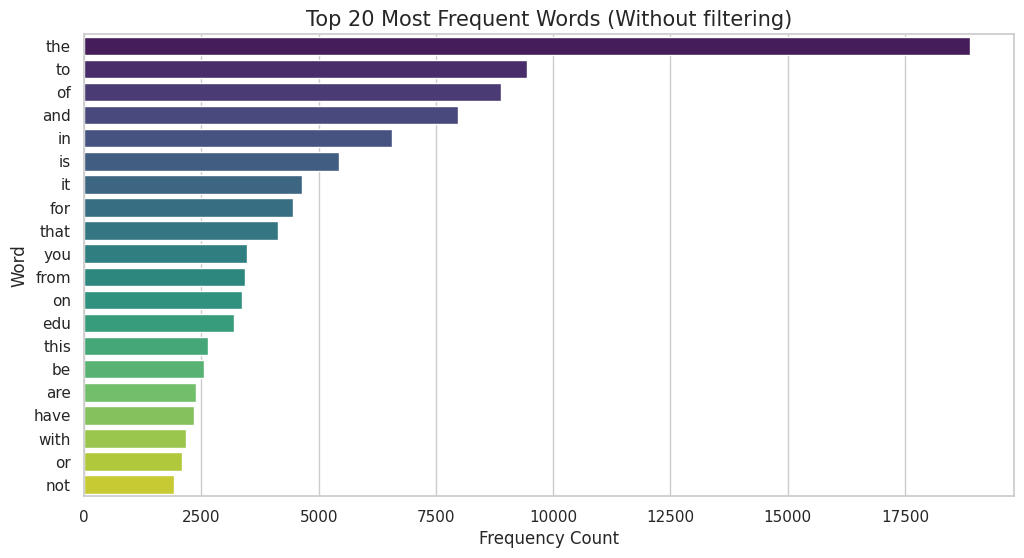

In [ ]:
# Plotting the top 20 words
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=df_common, palette='viridis')
plt.title('Top 20 Most Frequent Words (Without filtering)', fontsize=15)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Word', fontsize=12)
plt.show()

 The most common words are 'the', 'of', 'to'.

 These are 'Stop Words' and must be removed for LSA to work effectively.

# 3. Constructing the Matrix ($C$)

We convert the raw text into a numerical matrix using **TF-IDF (Term Frequency - Inverse Document Frequency)**.
* **TF:** Counts how often a word appears.
* **IDF:** Penalizes words that appear everywhere (like "the", "and" , etc... that we saw previously in the plot ).
        

This results in a matrix $C$ of size $(m \times n)$, where $m$ is the number of documents and $n$ is the number of unique words.

- The matrix C is sparse , due to the words like "the" , "and" , etc.. which are considered having zero weight in the matrix due to their high frequency and here it is treated as noise .

In [ ]:
# Initializing Vectorizer (limiting to top 2000 words for clarity)
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

# Creating the Matrix C (Document-Term Matrix)
X = vectorizer.fit_transform(dataset.data)

# Displaying Matrix Properties
print("----- Matrix C (Term-Document Matrix) ----")
print(f"Shape: {X.shape} ( Documents x Words)")

# Visualizing the full C matrix
feature_names = vectorizer.get_feature_names_out()
df_matrix = pd.DataFrame(X.toarray(), columns=feature_names)

display(df_matrix)


----- Matrix C (Term-Document Matrix) ----
Shape: (1771, 2000) ( Documents x Words)


,00,000,01,02,03,04,05,06,10,100,...,years,yes,yfn,york,young,ysu,zealand,zip,zoo,zoology
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.084217,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.068874,0.059979,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.07873,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.068698,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1767,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1768,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1769,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("\n--- All Feature Names (Words/Tokens) ---")
print(feature_names) # Display all the feature names


--- All Feature Names (Words/Tokens) ---
['00' '000' '01' ... 'zip' 'zoo' 'zoology']


# 4. Truncated SVD: The Decomposition

We now apply **Truncated SVD** to reduce the dimensions from 2,000 words down to **2 Latent Concepts** ($k=2$).

- Given an $m \times n$ matrix $C$ and a positive integer $k$ , we need to
find <span style="color:red">another $m \times n$ matrix $C_k$</span> to minimize the
Frobenius norm of $Z = C - C_k$

$$||Z||_F = \sqrt{\sum_{ij} Z_{ij}^2}$$

- The approximation of matrix $C$ using the top $k$ singular values is given by $C_k$:

$$C \approx C_k = U_k \Sigma_k V_k^T$$

Where:
* $U_k$ is the truncated left singular matrix ($m \times k$).
* $\Sigma_k$ is the diagonal matrix of the top $k$ singular values ($k \times k$).
* $V_k^T$ is the truncated right singular matrix ($k \times n$).

In [ ]:
# Applying SVD with k=2 components
k = 2
svd = TruncatedSVD(n_components=k, random_state=42)

X_reduced = svd.fit_transform(X) # Get U matrix ( transformed documents )
Sigma = svd.singular_values_
Vt = svd.components_

print(f" Matrix U (Docs x  Concepts): {X_reduced.shape}")
print(f" Matrix Sigma (Strength):     {Sigma.shape}")
print(f" Matrix V^T (Concepts x Words): {Vt.shape}")

print(f"\nSingular Values (Strength of Concept 1 & 2): {Sigma}")


 Matrix U (Docs x  Concepts): (1771, 2)
 Matrix Sigma (Strength):     (2,)
 Matrix V^T (Concepts x Words): (2, 2000)

Singular Values (Strength of Concept 1 & 2): [8.23784878 4.58606855]


In [ ]:
print("\n--- Truncated U Matrix (X_reduced) ---")
print(f"Shape: {X_reduced.shape}")
print(X_reduced)

print("\n--- Truncated Sigma Vector ---")
print(f"Shape: {Sigma.shape}")
print(Sigma)

print("\n--- Truncated V^T Matrix (Vt) ---")
print(f"Shape: {Vt.shape}")
print(Vt)


--- Truncated U Matrix (X_reduced) ---
Shape: (1771, 2)
[[ 0.218339    0.11845694]
 [ 0.19712727 -0.08452312]
 [ 0.17296573 -0.00260815]
 ...
 [ 0.20414674 -0.085642  ]
 [ 0.17647778  0.10118472]
 [ 0.22341946 -0.11344627]]

--- Truncated Sigma Vector ---
Shape: (2,)
[8.23784878 4.58606855]

--- Truncated V^T Matrix (Vt) ---
Shape: (2, 2000)
[[ 0.01724492  0.02790873  0.00947079 ...  0.00783477  0.03232391
   0.02008936]
 [ 0.00031107 -0.00991794  0.00072192 ... -0.00983224  0.11202969
   0.08042443]]


# 5. Interpretation: What are the "Latent Concepts"?

We inspect the $V_k^T$ matrix to understand what the math discovered.
* **Concept 1:** Usually captures the most common words across the dataset.
* **Concept 2:** Usually separates the topics (e.g., distinguishing "Space" words from "Car" words).

In [ ]:
# Function to print top words for each concept
terms = vectorizer.get_feature_names_out()

for i, component in enumerate(Vt):
    terms_comp = zip(terms, component)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:7]

    print(f"\nLatent Concept {i+1} Top Words:")
    for term, weight in sorted_terms:
        print(f" - {term} ({weight:.4f})")


Latent Concept 1 Top Words:
 - edu (0.3013)
 - com (0.2081)
 - space (0.1549)
 - car (0.1372)
 - subject (0.1279)
 - article (0.1271)
 - lines (0.1263)

Latent Concept 2 Top Words:
 - space (0.3754)
 - nasa (0.2646)
 - henry (0.2194)
 - alaska (0.1813)
 - toronto (0.1706)
 - gov (0.1600)
 - access (0.1253)


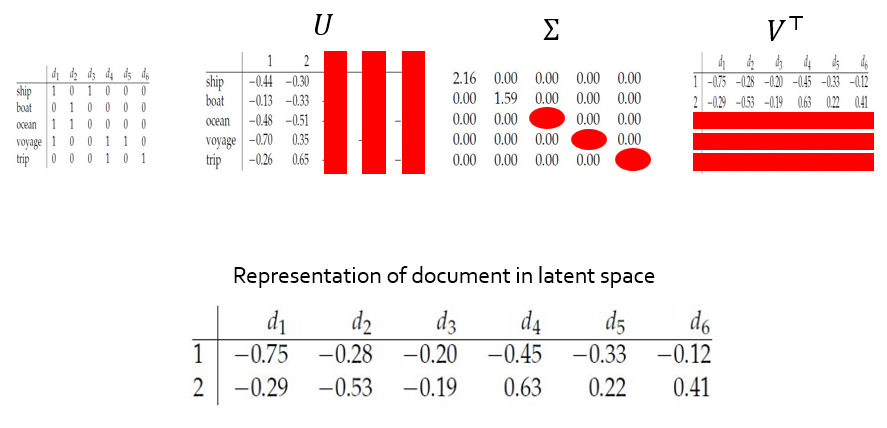

# 6. Visualization: The Semantic Space

Finally, we plot the documents using their new coordinates from the $U$ matrix.
* **X-axis:** Latent Concept 1
* **Y-axis:** Latent Concept 2

**Expected Result:** Documents from the same category (`sci.space`, `rec.autos`, etc.) should cluster together automatically.

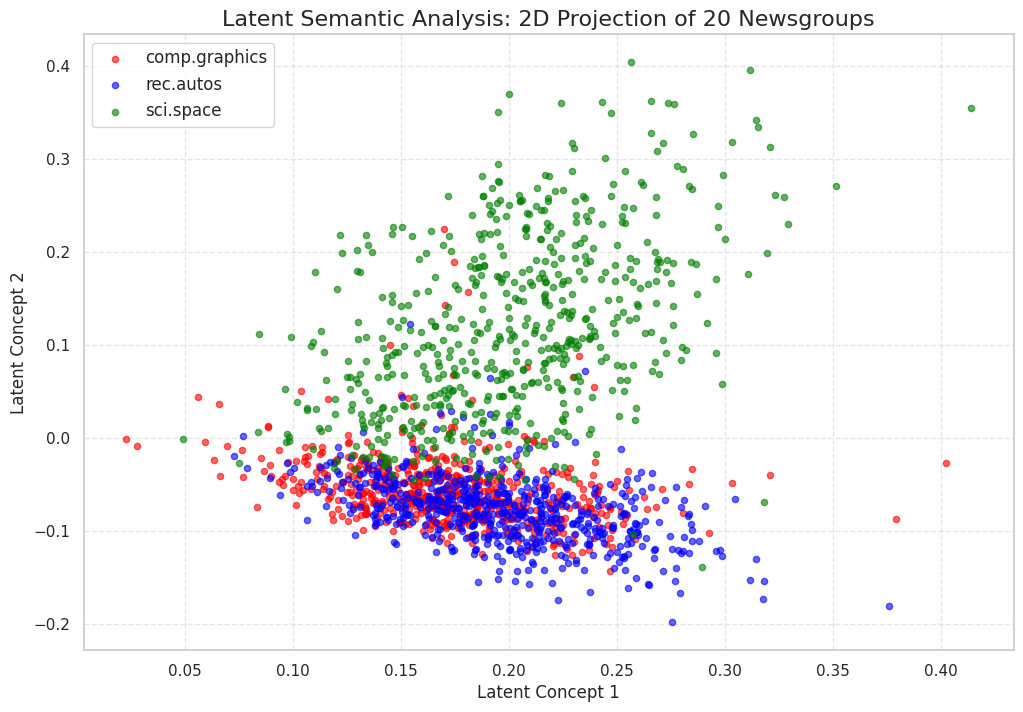

In [ ]:
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green']
target_names = dataset.target_names

for i, label in enumerate(target_names):
    # Finding the index of all docs belonging to this category
    idxs = np.where(dataset.target == i)[0]

    plt.scatter(X_reduced[idxs, 0], X_reduced[idxs, 1],
                c=colors[i], label=label, alpha=0.6, s=20)

plt.title('Latent Semantic Analysis: 2D Projection of 20 Newsgroups', fontsize=16)
plt.xlabel('Latent Concept 1', fontsize=12)
plt.ylabel('Latent Concept 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

This project demonstrates that **semantic meaning can be captured geometrically**.

By minimizing the Frobenius norm $||C - C_k||$, SVD found the optimal **low-rank subspace** that separates the topics.

# 7. Conclusion

In this project, we successfully utilized **Linear Algebra (SVD)** to analyze unstructured text.

1.  **Dimensionality Reduction:** We compressed the data from 2,000 dimensions to 2, effectively filtering out noise.
2.  **Latent Topic Discovery:** The visualization confirms that the algorithm automatically learned to distinguish between **Space**, **Cars**, and **Graphics** purely based on mathematical patterns in the term-document matrix.
3.  **Application:** This technique demonstrates the core mechanics behind modern search engines and recommendation systems.
4. This is a faster way of **Unsupervised learning** .